  c (5)
    b (4)
      d (3)
        e (2)
    e (1)


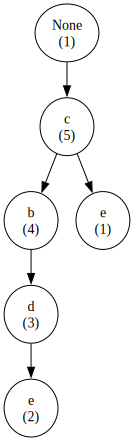

In [1]:
# 导入必要的库
from collections import defaultdict
from graphviz import Digraph

# 定义事务数据库
transactions = [
    ['a', 'b', 'c'],
    ['b', 'c', 'd', 'e'],
    ['a', 'c', 'e'],
    ['b', 'c', 'd'],
    ['b', 'c', 'd', 'e']
]

# 计算每个项的支持度
min_support = 3
item_support = defaultdict(int)

for transaction in transactions:
    for item in transaction:
        item_support[item] += 1

# 移除不满足最小支持度的项
item_support = {k: v for k, v in item_support.items() if v >= min_support}

# 对每个事务按项的支持度降序排序，并移除低支持度的项
sorted_transactions = []
for transaction in transactions:
    filtered_transaction = [item for item in transaction if item in item_support]
    sorted_transaction = sorted(filtered_transaction, key=lambda item: item_support[item], reverse=True)
    sorted_transactions.append(sorted_transaction)

# 定义FP-tree节点类
class FPNode:
    def __init__(self, name, count, parent):
        self.name = name
        self.count = count
        self.parent = parent
        self.children = {}
        self.link = None

    def increment(self, count):
        self.count += count

class FPTree:
    def __init__(self):
        self.root = FPNode(None, 1, None)
        self.headers = {}

    def add_transaction(self, transaction):
        current_node = self.root
        for item in transaction:
            if item in current_node.children:
                current_node.children[item].increment(1)
            else:
                new_node = FPNode(item, 1, current_node)
                current_node.children[item] = new_node
                if item not in self.headers:
                    self.headers[item] = new_node
                else:
                    current = self.headers[item]
                    while current.link:
                        current = current.link
                    current.link = new_node
            current_node = current_node.children[item]

    def display(self, node=None, indent=0):
        if node is None:
            node = self.root
        if node.name:
            print('  ' * indent + f'{node.name} ({node.count})')
        for child in node.children.values():
            self.display(child, indent + 1)

# 构建FP-tree
fp_tree = FPTree()
for transaction in sorted_transactions:
    fp_tree.add_transaction(transaction)

# 展示FP-tree
fp_tree.display()

# 定义函数来用Graphviz绘制FP-tree
def draw_fp_tree(tree):
    dot = Digraph(comment='FP-tree')

    def add_nodes_edges(node, parent_name=None):
        node_name = f'{node.name}\n({node.count})'
        if parent_name:
            dot.node(node_name, node_name)
            dot.edge(parent_name, node_name)
        else:
            dot.node(node_name, node_name)

        for child in node.children.values():
            add_nodes_edges(child, node_name)

    add_nodes_edges(tree.root)
    return dot

# 绘制FP-tree
fp_tree_dot = draw_fp_tree(fp_tree)

# 在Jupyter Notebook中显示FP-tree
fp_tree_dot.render('FP-Growth', format='png')
fp_tree_dot

In [4]:
import pandas as pd
from collections import defaultdict

# Step 1: 读取事务数据
data = {
    'TID': [1, 2, 3, 4, 5],
    'Itemset': [['a', 'b', 'c'], ['b', 'c', 'd', 'e'], ['a', 'c', 'e'], ['b', 'c', 'd'], ['b', 'c', 'd', 'e']]
}
df = pd.DataFrame(data)
print("原始事务数据：")
print(df)

# Step 2: 计算项的支持度，过滤低于最小支持度的项
min_support = 0.6
min_support_count = min_support * len(df)

item_support = defaultdict(int)
for items in df['Itemset']:
    for item in items:
        item_support[item] += 1

# 过滤低于最小支持度的项
item_support = {k: v for k, v in item_support.items() if v >= min_support_count}
print("\n满足最小支持度的项：")
print(item_support)

# Step 3: 重排事务数据
# 按支持度从高到低排序项
sorted_items = sorted(item_support.items(), key=lambda x: (-x[1], x[0]))

# 创建项的顺序字典
item_order = {item: i for i, (item, _) in enumerate(sorted_items)}

# 重排事务数据
def sort_items(itemset):
    return sorted([item for item in itemset if item in item_order], key=lambda item: item_order[item])

df['Sorted Itemset'] = df['Itemset'].apply(sort_items)
print("\n重排后的事务数据：")
print(df)

# Step 4: 构建FP树
class FPNode:
    def __init__(self, name, count, parent):
        self.name = name
        self.count = count
        self.parent = parent
        self.children = {}
        self.link = None

class FPTree:
    def __init__(self):
        self.root = FPNode('root', 1, None)
        self.header_table = {}

    def add_transaction(self, transaction):
        current_node = self.root
        for item in transaction:
            if item in current_node.children:
                current_node.children[item].count += 1
            else:
                new_node = FPNode(item, 1, current_node)
                current_node.children[item] = new_node

                # Update header table
                if item not in self.header_table:
                    self.header_table[item] = new_node
                else:
                    current_node_link = self.header_table[item]
                    while current_node_link.link is not None:
                        current_node_link = current_node_link.link
                    current_node_link.link = new_node

            current_node = current_node.children[item]

    def display(self, node=None, indent=0):
        if node is None:
            node = self.root
        print(' ' * indent, node.name, ' ', node.count)
        for child in node.children.values():
            self.display(child, indent + 2)

# 构建FP树
fp_tree = FPTree()
for items in df['Sorted Itemset']:
    fp_tree.add_transaction(items)

# 显示FP树
print("\nFP树结构：")
fp_tree.display()


原始事务数据：
   TID       Itemset
0    1     [a, b, c]
1    2  [b, c, d, e]
2    3     [a, c, e]
3    4     [b, c, d]
4    5  [b, c, d, e]

满足最小支持度的项：
{'b': 4, 'c': 5, 'd': 3, 'e': 3}

重排后的事务数据：
   TID       Itemset Sorted Itemset
0    1     [a, b, c]         [c, b]
1    2  [b, c, d, e]   [c, b, d, e]
2    3     [a, c, e]         [c, e]
3    4     [b, c, d]      [c, b, d]
4    5  [b, c, d, e]   [c, b, d, e]

FP树结构：
 root   1
   c   5
     b   4
       d   3
         e   2
     e   1
